In [1]:
import os
# These commands are for muting non-damaging errors - used for GPU
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Importing libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, GaussianNoise, RandomBrightness

import matplotlib.pyplot as plt
import collections

In [2]:
# Loading all three saved model
loaded_my_model = keras.models.load_model("cnn_mymodel_extendedFinal2.0.keras")
loaded_resnet_model = keras.models.load_model("resnet.keras")
loaded_resnet_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
loaded_efficient_model = keras.models.load_model("efficient.keras")
loaded_efficient_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

I0000 00:00:1759754072.948978     953 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# Loading the original test set
test_paths  = np.load("data_splits/test_paths.npy", allow_pickle=True)
test_labels  = np.load("data_splits/test_labels.npy", allow_pickle=True)

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32 

# Decode the image into the correct size image with 3 (RGB) channels
def process_path(file_path, label, imagesize):
    img = tf.io.read_file(file_path)                      
    img = tf.image.decode_jpeg(img, channels=3)           
    img = tf.image.resize(img, [imagesize,imagesize])
    return img, label

# Creating the test set 
def make_test_ds(test_paths, test_labels, imagesize, batch_size=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    ds = ds.map(lambda x, y: process_path(x, y, imagesize), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

test_ds_own = make_test_ds(test_paths, test_labels, imagesize=256)
test_ds_tl  = make_test_ds(test_paths, test_labels, imagesize=224)

In [20]:
# Evalutation of my models
test_loss_own, test_acc_own = loaded_my_model.evaluate(test_ds_own)
print(f"Test accuracy: {test_acc_own:.3f}")
test_loss_resnet, test_acc_resnet = loaded_resnet_model.evaluate(test_ds_tl)
print(f"Test accuracy: {test_acc_resnet:.3f}")
test_loss_efficient, test_acc_efficient = loaded_efficient_model.evaluate(test_ds_tl)
print(f"Test accuracy: {test_acc_efficient:.3f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8983 - loss: 0.4073
Test accuracy: 0.898
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9671 - loss: 0.1197
Test accuracy: 0.967
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9506 - loss: 0.1555
Test accuracy: 0.951


In [5]:
# Prediction of my models
y_pred_own = loaded_my_model.predict(test_ds_own)
y_pred_resnet = loaded_resnet_model.predict(test_ds_tl)
y_pred_efficient = loaded_efficient_model.predict(test_ds_tl)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step


In [6]:
# Creating arrays for each prediction
y_pred_own_labels = np.argmax(y_pred_own, axis=1)
y_pred_resnet_labels = np.argmax(y_pred_resnet, axis=1)
y_pred_efficient_labels = np.argmax(y_pred_efficient, axis=1)
y_true = test_labels   # this is already a NumPy array

# Creating an array of indicies of all images of missclassification
misclassified_own = np.where(y_pred_own_labels != y_true)[0]
misclassified_resnet = np.where(y_pred_resnet_labels != y_true)[0]
misclassified_efficient = np.where(y_pred_efficient_labels != y_true)[0]

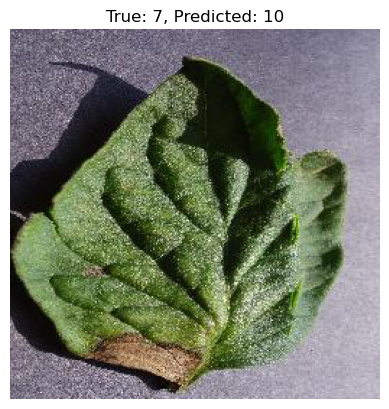

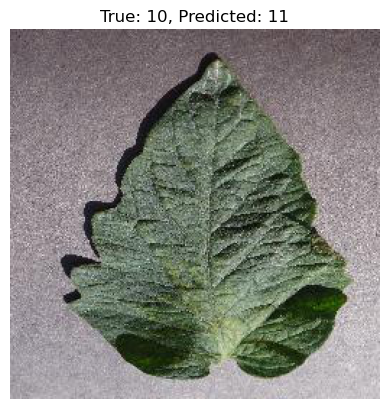

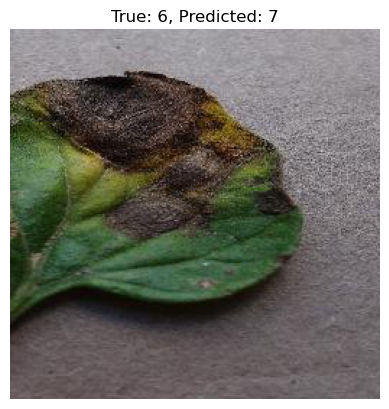

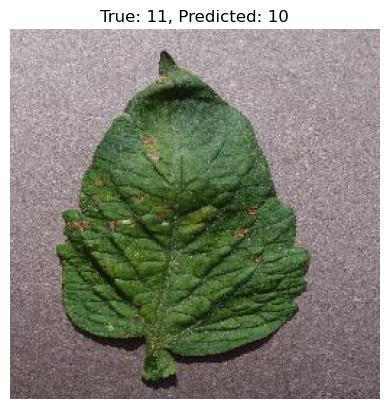

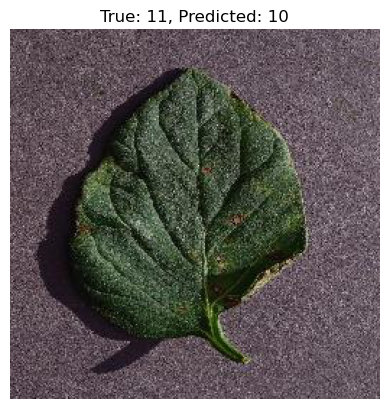

In [7]:
# Draws the images of missclassification and shows the correct and missclassified class
def missclassification_image(misclassified,quantity): 
    for idx in misclassified[:quantity]:
        img = plt.imread(test_paths[idx])
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {y_true[idx]}, Predicted: {y_pred_resnet_labels[idx]}")
        plt.show()

#Example of that function with ResNet
missclassification_image(misclassified_resnet,5)

In [8]:
# Count how many misclassified sample belong to each class for each model
counts_resnet = collections.Counter(y_true[misclassified_resnet])
counts_efficient = collections.Counter(y_true[misclassified_efficient])
counts_own = collections.Counter(y_true[misclassified_own])

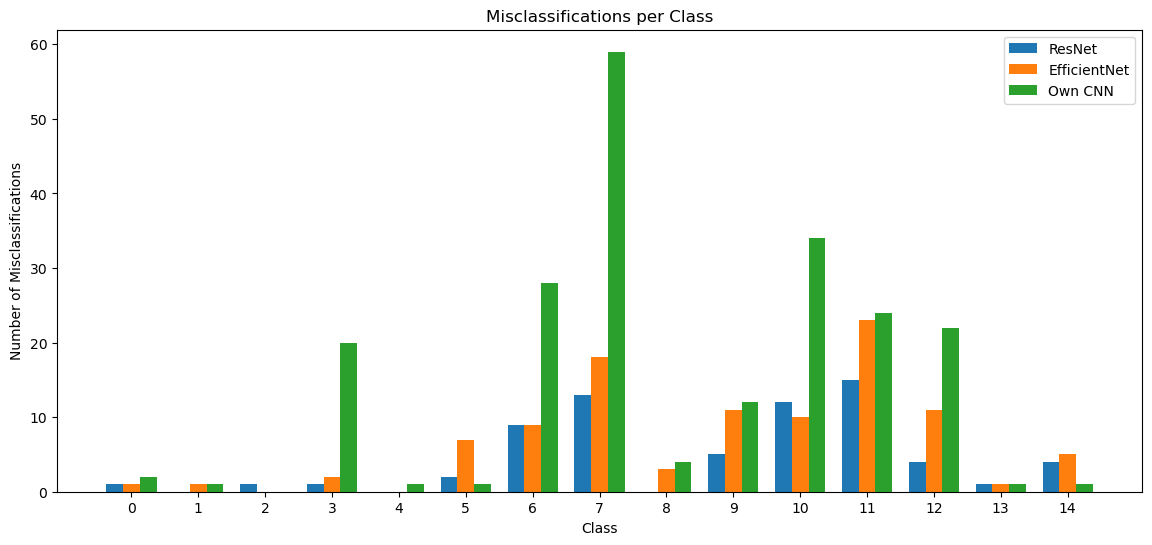

In [9]:
# Draws a Histogramm and compares how well each model does on all classes
def Histogramm_model_comparision(counts_own,counts_resnet,counts_efficient):
    owncnn_dict = dict(counts_own) 
    resnet_dict = dict(counts_resnet)
    efficient_dict = dict(counts_efficient)
    # Union of all classes that had misclassifications
    all_classes = sorted(owncnn_dict.keys() | resnet_dict.keys() | efficient_dict.keys())
    # X positions
    x = np.arange(len(all_classes))
    width = 0.25  
    # Get counts for each class 
    resnet_counts = [resnet_dict.get(c, 0) for c in all_classes]
    efficient_counts = [efficient_dict.get(c, 0) for c in all_classes]
    owncnn_counts = [owncnn_dict.get(c, 0) for c in all_classes]
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    rects1 = ax.bar(x - width, resnet_counts, width, label="ResNet")
    rects2 = ax.bar(x, efficient_counts, width, label="EfficientNet")
    rects3 = ax.bar(x + width, owncnn_counts, width, label="Own CNN")
    # Labels and formatting
    ax.set_xlabel("Class")
    ax.set_ylabel("Number of Misclassifications")
    ax.set_title("Misclassifications per Class")
    ax.set_xticks(x)
    ax.set_xticklabels(all_classes)
    ax.legend()
    plt.show()

# Histogramm for model comparision 
Histogramm_model_comparision(counts_own,counts_resnet,counts_efficient)

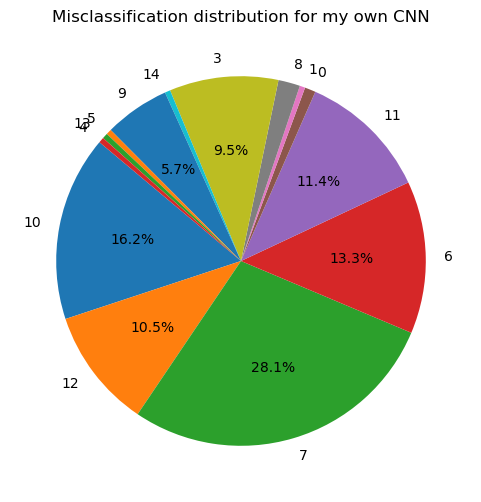


Detailed misclassification percentages for my own CNN:
Class 7: 28.10% (59 samples)
Class 10: 16.19% (34 samples)
Class 6: 13.33% (28 samples)
Class 11: 11.43% (24 samples)
Class 12: 10.48% (22 samples)
Class 3: 9.52% (20 samples)
Class 9: 5.71% (12 samples)
Class 8: 1.90% (4 samples)
Class 0: 0.95% (2 samples)
Class 1: 0.48% (1 samples)
Class 14: 0.48% (1 samples)
Class 5: 0.48% (1 samples)
Class 13: 0.48% (1 samples)
Class 4: 0.48% (1 samples)


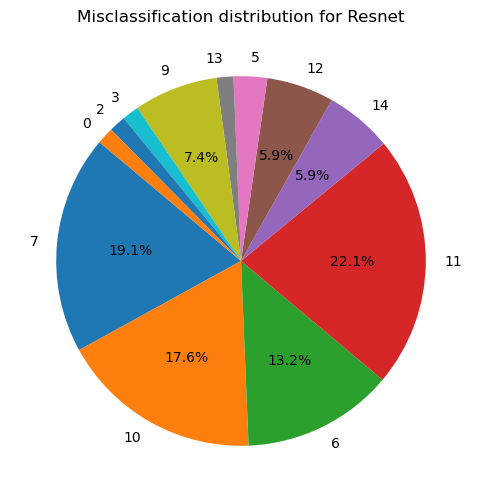


Detailed misclassification percentages for Resnet:
Class 11: 22.06% (15 samples)
Class 7: 19.12% (13 samples)
Class 10: 17.65% (12 samples)
Class 6: 13.24% (9 samples)
Class 9: 7.35% (5 samples)
Class 14: 5.88% (4 samples)
Class 12: 5.88% (4 samples)
Class 5: 2.94% (2 samples)
Class 13: 1.47% (1 samples)
Class 3: 1.47% (1 samples)
Class 2: 1.47% (1 samples)
Class 0: 1.47% (1 samples)


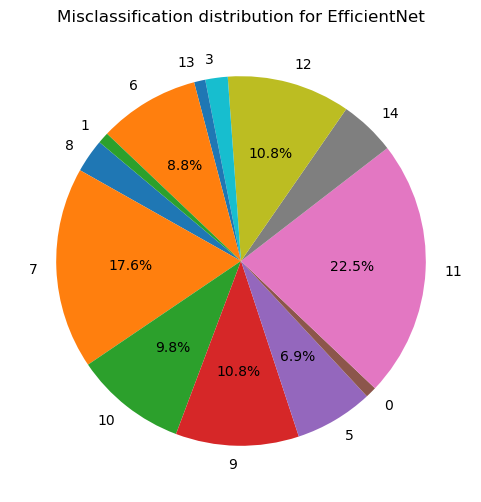


Detailed misclassification percentages for EfficientNet:
Class 11: 22.55% (23 samples)
Class 7: 17.65% (18 samples)
Class 9: 10.78% (11 samples)
Class 12: 10.78% (11 samples)
Class 10: 9.80% (10 samples)
Class 6: 8.82% (9 samples)
Class 5: 6.86% (7 samples)
Class 14: 4.90% (5 samples)
Class 8: 2.94% (3 samples)
Class 3: 1.96% (2 samples)
Class 0: 0.98% (1 samples)
Class 13: 0.98% (1 samples)
Class 1: 0.98% (1 samples)


In [10]:
#Draw a pie chart with the percentile of missclassification of each class
def plot_misclassification_pie(counter, model_name, min_pct=5):
    labels = list(counter.keys())
    sizes = np.array(list(counter.values()))
    total = sizes.sum()
    
    # More visibility -> removing the text of small missclassified classes 
    def autopct_func(pct):
        return ('%1.1f%%' % pct) if pct >= min_pct else ''  # hide small slices
        
    plt.figure(figsize=(6,6))
    wedges, texts, autotexts = plt.pie(
        sizes, 
        labels=labels, 
        autopct=autopct_func, 
        startangle=140
    )
    plt.title(f"Misclassification distribution for {model_name}")
    plt.show()
    
    # Print all percentages afterwards in descending order
    print(f"\nDetailed misclassification percentages for {model_name}:")
    for lbl, count in sorted(counter.items(), key=lambda x: x[1], reverse=True):
        pct = 100 * count / total
        print(f"Class {lbl}: {pct:.2f}% ({count} samples)")

# Pie Chart for each model
plot_misclassification_pie(counts_own, "my own CNN", min_pct=5)
plot_misclassification_pie(counts_resnet, "Resnet", min_pct=5)
plot_misclassification_pie(counts_efficient, "EfficientNet", min_pct=5)

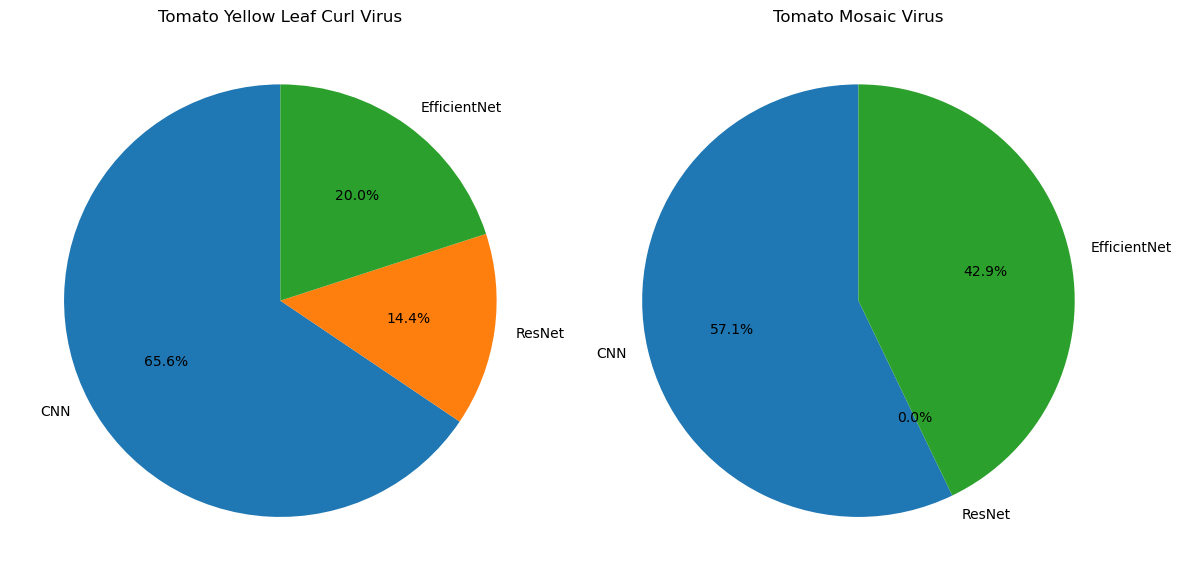

In [11]:
# Comparing models on the two most import classes (we dont want false negative as they are harmful)
def virus_on_models(counts_own,counts_resnet,counts_efficient):
    # my two virus classes
    yellowleaf = {
        "CNN": counts_own.get(7, 0),
        "ResNet": counts_resnet.get(7, 0),
        "EfficientNet": counts_efficient.get(7, 0)
    }
    mosaic = {
        "CNN": counts_own.get(8, 0),
        "ResNet": counts_resnet.get(8, 0),
        "EfficientNet": counts_efficient.get(8, 0)
    }
    
    # Plot two pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Yellow Leaf Curl pie
    axes[0].pie(
        yellowleaf.values(), 
        labels=yellowleaf.keys(), 
        autopct='%1.1f%%', 
        startangle=90
    )
    axes[0].set_title("Tomato Yellow Leaf Curl Virus")
    
    # Mosaic Virus pie
    axes[1].pie(
        mosaic.values(), 
        labels=mosaic.keys(), 
        autopct='%1.1f%%', 
        startangle=90
    )
    axes[1].set_title("Tomato Mosaic Virus")
    
    plt.tight_layout()
    plt.show()

# Pie Chart of comparision of all models on the two virus classes
virus_on_models(counts_own,counts_resnet,counts_efficient)

In [12]:
# Creating a new data set with more realistic images
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.5),        
    RandomZoom(0.4),            
    RandomContrast(0.5),        
    RandomBrightness(0.3),      
    GaussianNoise(0.2),        
    # RandomCrop(height, width) isnt added because if the required sizes for the model
])

# Decode the image into the correct size image with 3 (RGB) channels
def process_path_aug(file_path, label, imagesize):
    img = tf.io.read_file(file_path)                      
    img = tf.image.decode_jpeg(img, channels=3)           
    img = tf.image.resize(img, [imagesize, imagesize])
    img = data_augmentation(img)
    return img, label

# Creating the augmented test set 
def make_augmented_test_ds(test_paths, test_labels, imagesize, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    ds = ds.map(lambda x, y: process_path_aug(x, y, imagesize), 
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

test_ds_own_aug = make_augmented_test_ds(test_paths, test_labels, imagesize=256)
test_ds_tl_aug  = make_augmented_test_ds(test_paths, test_labels, imagesize=224)

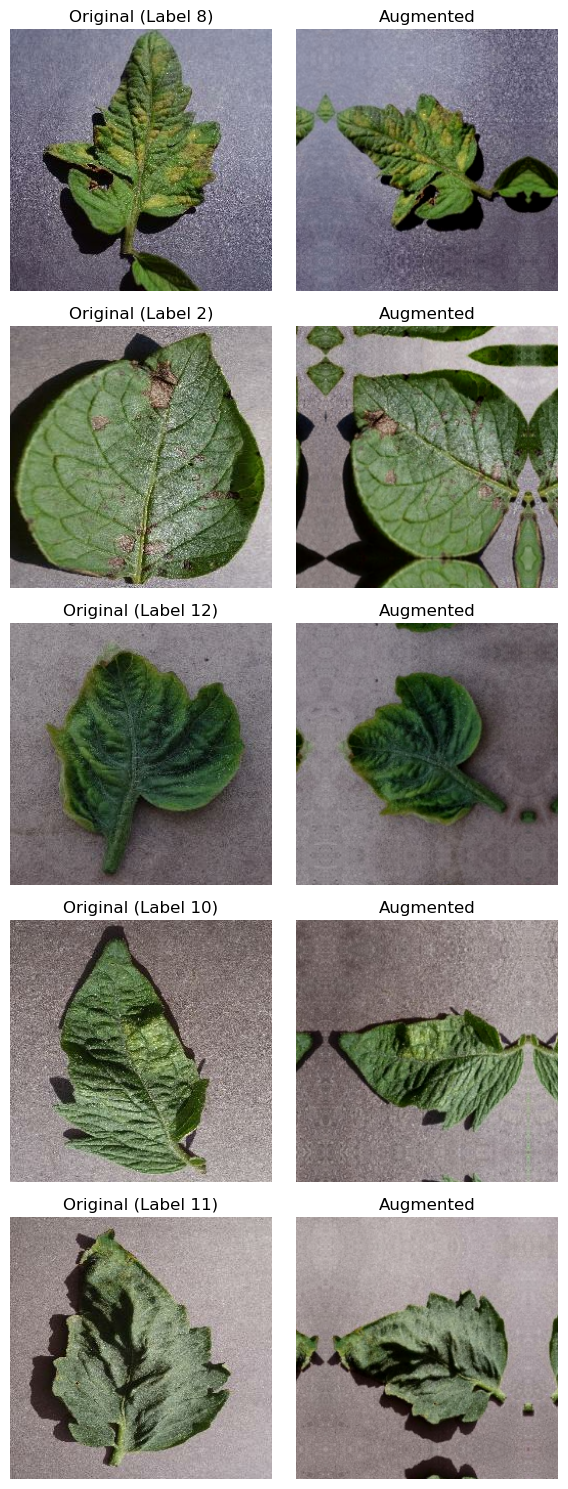

In [13]:
# Take 5 examples of the original and the augmented image

# Take the first batch 
clean_batch = next(iter(test_ds_own.take(1)))
aug_batch   = next(iter(test_ds_own_aug.take(1)))

clean_images, clean_labels = clean_batch
aug_images, aug_labels     = aug_batch

# Plot side by side
fig, axes = plt.subplots(5, 2, figsize=(6, 15))

# Drawing my five examples
for i in range(5):
    # Original
    axes[i, 0].imshow(clean_images[i].numpy().astype("uint8"))
    axes[i, 0].set_title(f"Original (Label {clean_labels[i].numpy()})")
    axes[i, 0].axis("off")

    # Augmented
    axes[i, 1].imshow(aug_images[i].numpy().astype("uint8"))
    axes[i, 1].set_title(f"Augmented")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [14]:
# Evalutation of my models
test_loss_own_aug, test_acc_own_aug = loaded_my_model.evaluate(test_ds_own_aug)
print(f"Test accuracy: {test_acc_own_aug:.3f}")
test_loss_resnet_aug, test_acc_resnet_aug = loaded_resnet_model.evaluate(test_ds_tl_aug)
print(f"Test accuracy: {test_acc_resnet_aug:.3f}")
test_loss_efficient_aug, test_acc_efficient_aug = loaded_efficient_model.evaluate(test_ds_tl_aug)
print(f"Test accuracy: {test_acc_efficient_aug:.3f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.4390 - loss: 3.8195
Test accuracy: 0.439
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5305 - loss: 2.8911
Test accuracy: 0.531
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6967 - loss: 1.0419
Test accuracy: 0.697


In [15]:
# Prediction of my models
y_pred_own_aug = loaded_my_model.predict(test_ds_own_aug)
y_pred_resnet_aug = loaded_resnet_model.predict(test_ds_tl_aug)
y_pred_efficient_aug = loaded_efficient_model.predict(test_ds_tl_aug)

# Creating arrays for each prediction
y_pred_own_labels_aug = np.argmax(y_pred_own_aug, axis=1)
y_pred_resnet_labels_aug = np.argmax(y_pred_resnet_aug, axis=1)
y_pred_efficient_labels_aug = np.argmax(y_pred_efficient_aug, axis=1)
y_true = test_labels   

# Creating an array of indicies of all images of missclassification
misclassified_own_aug = np.where(y_pred_own_labels_aug != y_true)[0]
misclassified_resnet_aug = np.where(y_pred_resnet_labels_aug != y_true)[0]
misclassified_efficient_aug = np.where(y_pred_efficient_labels_aug != y_true)[0]

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


In [16]:
# Count how many misclassified sample belong to each class for each model
counts_resnet_aug = collections.Counter(y_true[misclassified_resnet_aug])
counts_efficient_aug = collections.Counter(y_true[misclassified_efficient_aug])
counts_own_aug = collections.Counter(y_true[misclassified_own_aug])

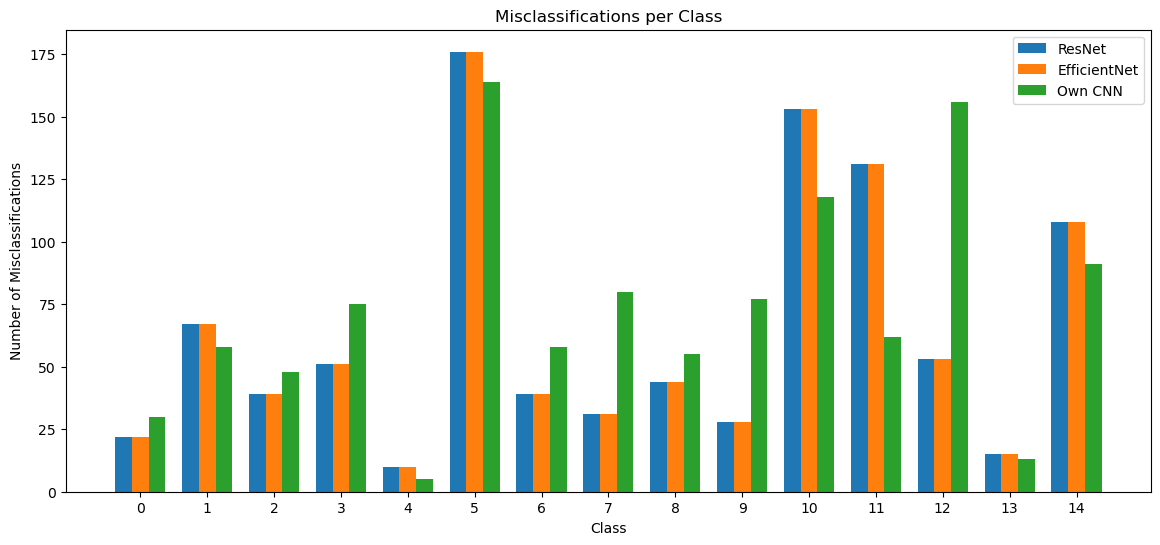

In [17]:
# Histogramm for model comparision with the augmented test set
Histogramm_model_comparision(counts_own_aug,counts_resnet_aug,counts_resnet_aug)

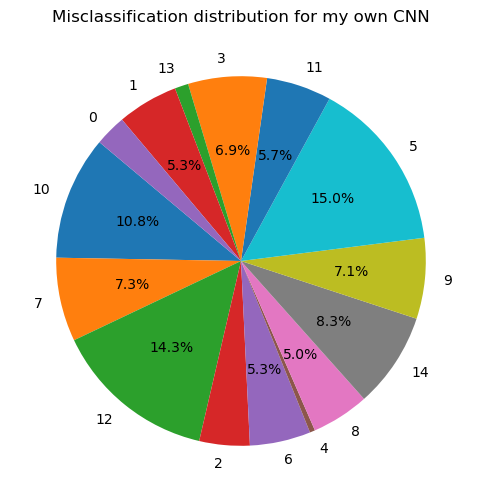


Detailed misclassification percentages for my own CNN:
Class 5: 15.05% (164 samples)
Class 12: 14.31% (156 samples)
Class 10: 10.83% (118 samples)
Class 14: 8.35% (91 samples)
Class 7: 7.34% (80 samples)
Class 9: 7.06% (77 samples)
Class 3: 6.88% (75 samples)
Class 11: 5.69% (62 samples)
Class 6: 5.32% (58 samples)
Class 1: 5.32% (58 samples)
Class 8: 5.05% (55 samples)
Class 2: 4.40% (48 samples)
Class 0: 2.75% (30 samples)
Class 13: 1.19% (13 samples)
Class 4: 0.46% (5 samples)


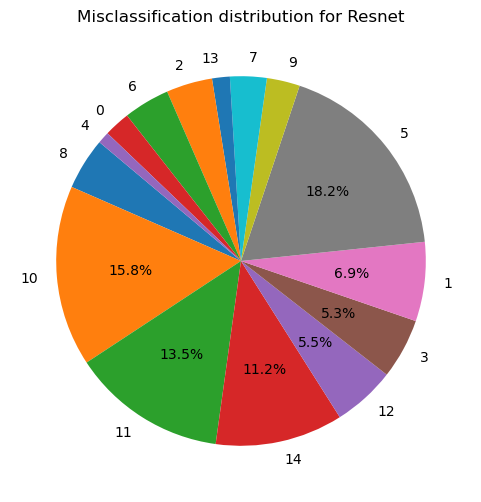


Detailed misclassification percentages for Resnet:
Class 5: 18.20% (176 samples)
Class 10: 15.82% (153 samples)
Class 11: 13.55% (131 samples)
Class 14: 11.17% (108 samples)
Class 1: 6.93% (67 samples)
Class 12: 5.48% (53 samples)
Class 3: 5.27% (51 samples)
Class 8: 4.55% (44 samples)
Class 2: 4.03% (39 samples)
Class 6: 4.03% (39 samples)
Class 7: 3.21% (31 samples)
Class 9: 2.90% (28 samples)
Class 0: 2.28% (22 samples)
Class 13: 1.55% (15 samples)
Class 4: 1.03% (10 samples)


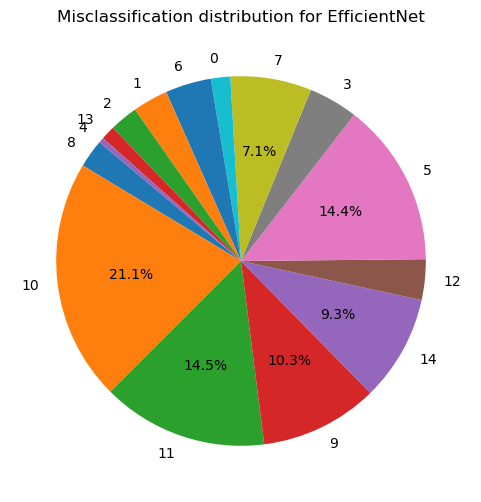


Detailed misclassification percentages for EfficientNet:
Class 10: 21.14% (137 samples)
Class 11: 14.51% (94 samples)
Class 5: 14.35% (93 samples)
Class 9: 10.34% (67 samples)
Class 14: 9.26% (60 samples)
Class 7: 7.10% (46 samples)
Class 3: 4.32% (28 samples)
Class 6: 4.01% (26 samples)
Class 12: 3.55% (23 samples)
Class 1: 3.09% (20 samples)
Class 8: 2.47% (16 samples)
Class 2: 2.47% (16 samples)
Class 0: 1.70% (11 samples)
Class 13: 1.23% (8 samples)
Class 4: 0.46% (3 samples)


In [18]:
# Pie Chart for each model with the augmented test set
plot_misclassification_pie(counts_own_aug, "my own CNN", min_pct=5)
plot_misclassification_pie(counts_resnet_aug, "Resnet", min_pct=5)
plot_misclassification_pie(counts_efficient_aug, "EfficientNet", min_pct=5)

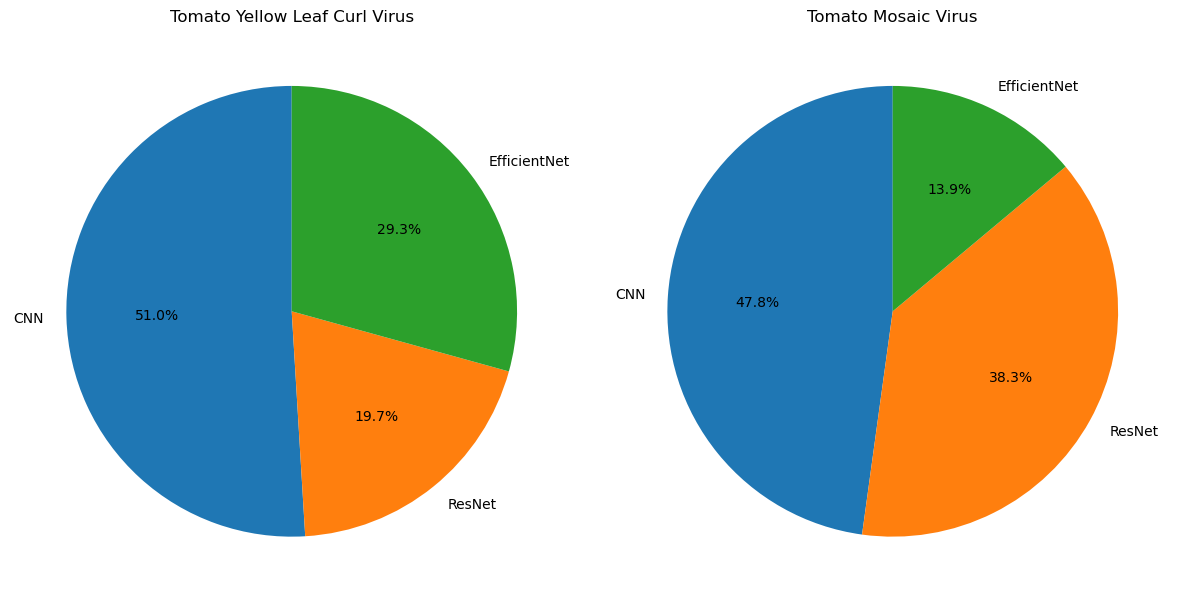

In [19]:
# Pie Chart of comparision of all models on the two virus classes on the augmented test set
virus_on_models(counts_own_aug,counts_resnet_aug,counts_efficient_aug)